# Behavioral Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

### Imports

In [5]:
import pandas as pd; import seaborn as sb; import warnings; import scipy; import re; import os
from analysis_helpers import *; import itertools; from scipy import stats
import random; import pandas as pd; import numpy as np; from sklearn import datasets, linear_model; from sklearn.linear_model import LinearRegression; import statsmodels.api as sm
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [6]:
exp1 = pd.DataFrame.from_csv('/Users/kirstenziman/Documents/NEW_DIRECTORY/new_place/attention-memory-task/parsed_data/behavioral_data_exp1.csv')
exp2 = pd.DataFrame.from_csv('/Users/kirstenziman/Documents/NEW_DIRECTORY/new_place/attention-memory-task/parsed_data/behavioral_data_exp2.csv')

# Data Organize

In [7]:
# Make sure all images labeled by their inherent category (use image filename)
exp2.ix[ exp2['Memory Image'].str.contains("sun", na=False),'Category']='Place'
exp2.ix[~exp2['Memory Image'].str.contains("sun", na=False),'Category']='Face'
exp2.loc[exp2['Trial Type']=='Presentation','Category']=np.nan

# Make sure all memory trials are numbered
exp1.loc[exp1['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8
exp2.loc[exp2['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8

### Exp2: add column for the last-cued category before each memory block

In [8]:
exp2['Last Cued'] = np.nan

for sub in exp2['Subject'].unique():
    for run in exp2['Run'].unique():
        
        # obtain cued category from the last presentation trial
        last_cat = exp2[(exp2['Trial Type']=='Presentation')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run)
                       & (exp2['Trial']==9)]['Cued Category'].item()
        # print(last_cat)
        
        # assign to this memory run
        exp2.loc[(exp2['Trial Type']=='Memory')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run),'Last Cued'] = last_cat

### Re-Label Novel Images by Cued or Uncued category

In [9]:
exp1 = add_nov_label(exp1)
exp2 = add_nov_label(exp2, column_name ='Last Cued')

### Working version of the data with all Novel images together (not splti by cued or uncued)

In [10]:
exp2_Novel = exp2.replace(to_replace=['Nov_Cued','Nov_Un'], value='Novel')
exp1_Novel = exp1.replace(to_replace=['Nov_Cued','Nov_Un'], value='Novel')

In [11]:
# Note : subject 28 has all trials ending in 'Place' cue !
# exp2[(exp2['Subject']==28) & (exp2['Trial Type']=='Presentation') & (exp2['Trial']==9)]['Cued Category']

# Stats

Below are all of the statistical tests done on the behavioral data, in the order they appear in the paper

### Reaction Time Stats (Cued vs. Uncued side)

In [12]:
# reaction time for attended side - unattended side, EXP 1 VS EXP 2

In [13]:
# Experiment 1
exp1_gr = exp1.groupby(['Subject','Cue Validity'], as_index=False).mean()

scipy.stats.ttest_rel(exp1_gr[exp1_gr['Cue Validity']==0]['Attention Reaction Time (s)'], 
                            exp1_gr[exp1_gr['Cue Validity']==1]['Attention Reaction Time (s)'])

Ttest_relResult(statistic=2.726564495656624, pvalue=0.010744006694709042)

In [14]:
# Experiment 2
exp2_gr = exp2.groupby(['Subject','Cue Validity'], as_index=False).mean()

scipy.stats.ttest_rel(exp2_gr[exp2_gr['Cue Validity']==0]['Attention Reaction Time (s)'], 
                            exp2_gr[exp2_gr['Cue Validity']==1]['Attention Reaction Time (s)'])

Ttest_relResult(statistic=-0.015703450175793242, pvalue=0.9875785155263901)

### Compare Fully Attended Images to all Other images

In [36]:
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    Fulls  = []
    Others = []
    
    for s in d['Subject'].unique():
        
        Fulls.append(d[(d['Subject']==s)&(d['Attention Level']=='Full')]['Familiarity Rating'].mean())
        Others.append(d[(d['Subject']==s) &(d['Attention Level']!='Full')]['Familiarity Rating'].mean())
        
    print(label)
    print(scipy.stats.ttest_rel(Fulls, Others))
    print()

Experiment_1
Ttest_relResult(statistic=9.396112809093742, pvalue=2.6596964490466333e-10)

Experiment_2
Ttest_relResult(statistic=5.567191437174967, pvalue=5.252532785886715e-06)



### Face versus Scene

In [12]:
for exp,label in zip([exp1, exp2],['exp 1','exp 2']):
    f_p = exp.groupby(['Category', 'Subject', 'Attention Level'], as_index=False).mean()
    print(label)
    print(scipy.stats.ttest_rel(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')]['Familiarity Rating'], 
                                f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')]['Familiarity Rating']))

          

exp 1
Ttest_relResult(statistic=5.5990321530636935, pvalue=4.809466356149415e-06)
exp 2
Ttest_relResult(statistic=3.6122493003149714, pvalue=0.001133445225594122)


### Categories vs Novel

In [13]:
for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    Cats  = []
    Novs = []
    
    for s in d['Subject'].unique():
        
        Cats.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Category']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='Novel')]['Familiarity Rating'].mean())

    print(label)
    print(scipy.stats.ttest_rel(Cats, Novs))
    print()

Experiment_1
Ttest_relResult(statistic=5.248448043551901, pvalue=1.2716251947496808e-05)

Experiment_2
Ttest_relResult(statistic=1.9557281622268197, pvalue=0.060192697179814646)



### Side vs Novel

In [14]:
for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    Sides  = []
    Novs = []
    
    for s in d['Subject'].unique():
        
        Sides.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Side']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='Novel')]['Familiarity Rating'].mean())

    print(label)
    print(scipy.stats.ttest_rel(Sides, Novs))
    print()

Experiment_1
Ttest_relResult(statistic=0.5564111088638143, pvalue=0.5821983386952392)

Experiment_2
Ttest_relResult(statistic=6.85034017352441, pvalue=1.5929721367210212e-07)



# Category versus Novel Diffs

In [15]:
# Exp 1: mean(Side & Full) - mean(Novel)
# versus
# Exp 2: mean(Side & Full) - mean(Novel)

# Exp 1: mean(Cat & Full) - mean(Novel)
# versus
# Exp 2: mean(Cat & Full) - mean(Novel)


# Experiment 1: ( (mean(Cat & Full) - mean(Novel))  -    (mean(Side & Full) - mean(Novel)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(Novel))   -    (mean(Side & Full) - mean(Novel)) ) 

In [16]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        side = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full']))]['Familiarity Rating'].mean()
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        
        cat_nov.append(cat - nov)
        side_nov.append(side - nov)
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print()
    
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs[label].append(diff)
    
    print(len(diff))
    

Experiment_1
Ttest_relResult(statistic=2.0408065546020406, pvalue=0.0504655227194427)

30
Experiment_2
Ttest_relResult(statistic=-3.659203543584972, pvalue=0.0010005362417606367)

30


### Cued versus Uncued Novel Images

In [17]:
for d,label in zip([exp1, exp2],['exp1','exp2']):
    
    d = d.groupby(['Subject','Attention Level'], as_index=False).mean()
    
    print(label)
    print(scipy.stats.ttest_rel(d[d['Attention Level']=='Nov_Cued']['Familiarity Rating'], 
                                d[d['Attention Level']=='Nov_Un']['Familiarity Rating']))
    print()
    

exp1
Ttest_relResult(statistic=5.644488500528174, pvalue=4.241252223029619e-06)

exp2
Ttest_relResult(statistic=0.22263341929217778, pvalue=0.8253814425522065)



### Attended Category versus Unattended Category images

In [18]:
# for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
#     att   = []
#     unatt = []
    
#     for s in d['Subject'].unique():
        
#         att.append(d[(d['Subject']==s)&(d['Attention Level'].isin(['Full','Category']))]['Familiarity Rating'].mean())
#         unatt.append(d[(d['Subject']==s) &(d['Attention Level'].isin(['Side','None']))]['Familiarity Rating'].mean())
        
#     print(label)
#     print(scipy.stats.ttest_rel(att, unatt))
#     print()

# Category versus novel diffs

In [19]:
# Exp 1: mean(Side & Full) - mean(Novel)
# versus
# Exp 2: mean(Side & Full) - mean(Novel)

# Exp 1: mean(Cat & Full) - mean(Novel)
# versus
# Exp 2: mean(Cat & Full) - mean(Novel)


# Experiment 1: ( (mean(Cat & Full) - mean(Novel))  -    (mean(Side & Full) - mean(Novel)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(Novel))   -    (mean(Side & Full) - mean(Novel)) )    

# [(full & Cat) - (Side & None)] vs [ Nov_Cued - Nov_Uncued ]

# 3.95 change to separate for each

# cat & Full - Nov vs SIde and Full - Nov for each

# [(Side & Full) - Novel] Exp 1 vs Exp 2

In [22]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}
side_diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        side = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full']))]['Familiarity Rating'].mean()
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        # nov_cued   =  
        # nov_uncued = 
        
        cat_nov.append(cat - nov)
        side_nov.append(side - nov)
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print()
    
    side_diffs[label] = side_nov
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs[label] = diff
    
print()
print('Feature boost relative to Location boost, Exp1 vs Exp 2')
print(scipy.stats.ttest_ind(diffs['Experiment_1'], diffs['Experiment_2']))
print()
print('Location boost relative to novel, Exp2 vs Exp1')
print(scipy.stats.ttest_ind(side_diffs['Experiment_2'], side_diffs['Experiment_1']))

Experiment_1
Ttest_relResult(statistic=2.0408065546020406, pvalue=0.0504655227194427)

Experiment_2
Ttest_relResult(statistic=-3.659203543584972, pvalue=0.0010005362417606367)


Feature boost relative to Location boost, Exp1 vs Exp 2
Ttest_indResult(statistic=3.9456393034115114, pvalue=0.00021738230280496541)

Location boost relative to novel, Exp2 vs Exp1
Ttest_indResult(statistic=0.051829281712867485, pvalue=0.9588428178685637)


### t-tests comparing familiarity for (attended category + attended location old images) versus (unattended category + attended location old images)


# CHANGE TO : (Full - Cat) vs (Side - None) 

In [23]:
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    a_s = []
    b_s = []

    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        
        a = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full','Cat']))]['Familiarity Rating'].mean()
        b = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side', 'Full','None']))]['Familiarity Rating'].mean()
        # nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        
        a_s.append(a)
        b_s.append(b)
        
    print(label)
    print(scipy.stats.ttest_rel(a_s, b_s))
    print()

Experiment_1
Ttest_relResult(statistic=8.97100971289351, pvalue=7.300903452759381e-10)

Experiment_2
Ttest_relResult(statistic=3.688022702047958, pvalue=0.000926607823310365)



# Plot Data

# Violin Plots - Full Data

Experiment_1: Average Familiarity by Attention Level


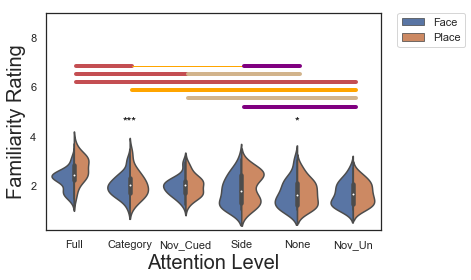

Experiment_2: Average Familiarity by Attention Level
Nov_Cued: independent ttest
Nov_Un: independent ttest


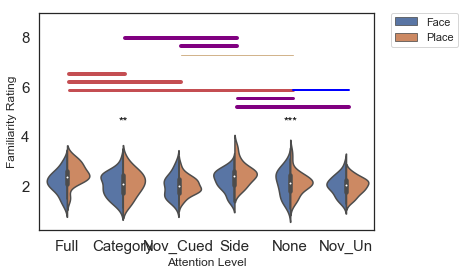

In [25]:
stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']
col_neg = ['grey','blue', 'purple', 'tan', 'orange', 'r']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)

# for each experiment, group and plot
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    d = d[d['Trial Type']=='Memory']
    
    data = d.groupby(['Subject','Attention Level', 'Category'], as_index = False).mean()
    print(label + ': Average Familiarity by Attention Level')
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data, hue='Category', split=True,
                 order=cats)
    sb_plot.set(ylim=(.2, 9))
    ax1 = sb_plot.axes
    
    
    ### WITHIN VIOLIN SIGNIFICANCE FOR PLOTTING ###
    t_draw = {}
    
    for c in data['Attention Level'].unique():
        
        first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
        second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
        
        if len(first)==len(second):
            t = scipy.stats.ttest_rel(first, second)
        else:
            print(c+': independent ttest')
            t = scipy.stats.ttest_ind(first, second)  
        
        if t[1]<.001:
            t_draw[c] = '***'
            
        elif t[1]<.01:
            t_draw[c] = '**'
        
        elif t[1]<.05:
            t_draw[c] = '*'
            
        elif t[1]<.056:
            t_draw[c] = '+'
    
    ### SIGNIFICANCE FOR PLOTTING ###
    stat_dict = {}
    #stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}
    k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(cats, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])
        stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

        # dictionary where every key is a pair of sig dif categories 
        if t[1]<.056:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}
        
    ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category
    
        x = sig_bars(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
                
                #print('first')
                #print(plotted_cats)
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
            
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line
                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                            
                        plotted_cats.append(b['categories'])
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))
                        
                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]

                        plotted_cats.append((l,plotted_cats[-1][1]))
                        plotted_cats.append((fake_first,plotted_cats[-1][1]))
           
            line_counter += .3
                        
            if type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+5.2
                new_to_be_plotted.append(line)

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[cats.index(each['categories'][0])])

    ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category 
    
        x = sig_bars_neg(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
                
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line

                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                        
                        plotted_cats.append(b['categories'])
                        
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))

                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]
                                       
            line_counter += .3
            
                                    
            if len(plotted_cats)>0 and type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+7.3
                new_to_be_plotted.append(line)
                

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[-cats.index(each['categories'][1])])
    for stars in t_draw:
        ax1.text((cats.index(stars)+1), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')
        
        

    plt.savefig(label + "vio.pdf")    
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# Timecourse Plots

In [26]:
# Apply sliding window
window_length = 20

exp1_mean_window = apply_window(exp1, window_length)
exp2_mean_window = apply_window(exp2, window_length)

# prepare data for plotting
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
    
    # assign data to dictionary key
    plot_data[key] = group_melt

In [27]:
# Prepare data for plotting
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
                           #value_vars=['Category', 'Full','None','Nov_Cued','Nov_Un','Side'])
    
    # assign data to dictionary key
    plot_data[key] = group_melt
    
# plotting color key
palette = sb.color_palette("RdBu", 20)
# Cued category    -->  warm colors 
# Uncued category  -->  cool colors

### Sliding Window - Familiarity Over Time

### Sliding Window - Novel Images

Exp 2: Novel Images that are not in the last-cued category have significantly higher familiarity ratings at the beginning of the memory block (first window) than they do at the end of the memory block (last window).

In [28]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))


exp1: Sliding Window - Novel Images Only
[True]


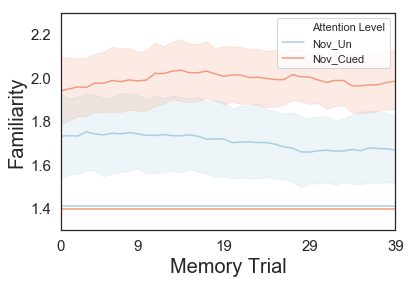

exp2: Sliding Window - Novel Images Only
[False]


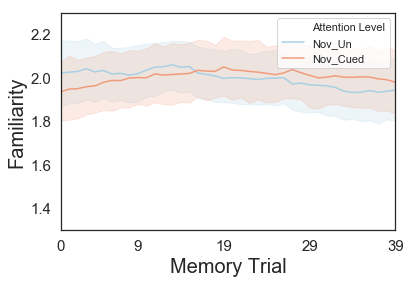

In [29]:
import scipy

sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(key + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    ax.set(xlim=(0, 39))
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Nov_Un'])]['timepoint_t_truth'].unique())
    
    # add gret lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        #print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        # plt.axvline(x, .1, .3, color='red')
    
    plt.xticks([0, 9, 19, 29, 39])
    plt.savefig('Novel_tcourse_'+label+'.pdf')
    plt.show()    
    

### Novel Image Difference Scores

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     180.0
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           3.41e-16
Time:                        19:17:07   Log-Likelihood:                 27.564
No. Observations:                  40   AIC:                            -53.13
Df Residuals:                      39   BIC:                            -51.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trial          0.0115      0.001     13.415      0.0

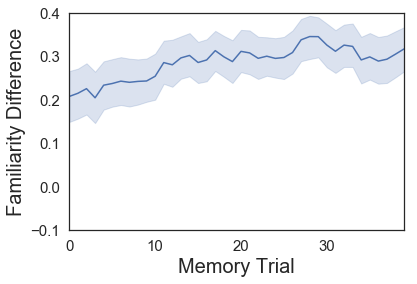

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     19.34
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           8.21e-05
Time:                        19:17:14   Log-Likelihood:                 72.485
No. Observations:                  40   AIC:                            -143.0
Df Residuals:                      39   BIC:                            -141.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trial          0.0012      0.000      4.397      0.0

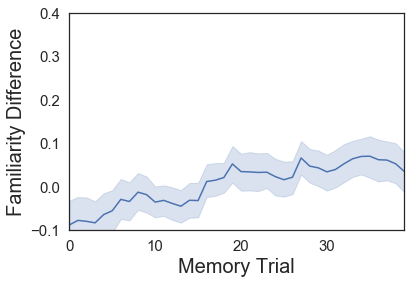

In [30]:
for exp in plot_data.keys():
    
    trial_avs = plot_data[exp].groupby(['Trial','Attention Level','Subject'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan
    
    for s in trial_avs['Subject'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            difference = first - second
            #print(difference)
            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['Subject']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
    ax.set(xlim=(0, 39))
    
    trial_av_grp = trial_avs.groupby(['Trial'], as_index=False).mean()
    est = sm.OLS(np.array(trial_av_grp['Nov_Diffs']), trial_av_grp['Trial'])
    print(est.fit().summary())
    print(est.fit().f_pvalue)
    print()
        
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    plt.savefig('Novel_Diff_'+ exp +'.pdf')
    print(exp)
    plt.show()


### Sliding Window - Images in Uncued Category


In [31]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))


Experiment 1: Sliding Window - Uncued Category Images


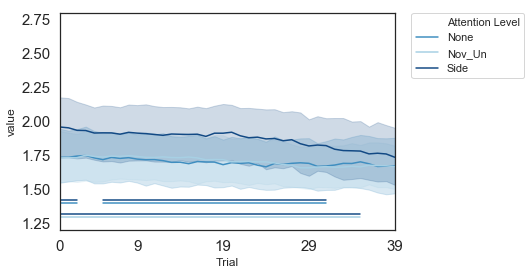

Experiment 2: Sliding Window - Uncued Category Images


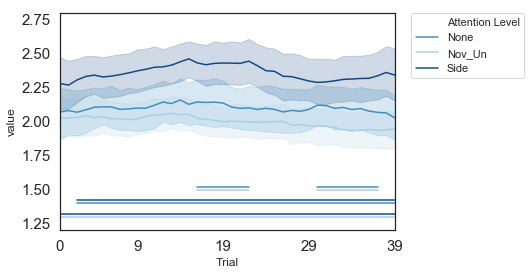

In [32]:
from itertools import groupby
from operator import itemgetter


sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))

    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                        
        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','None'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        else:
            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
    
        else:
            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])

        
    plt.xticks([0, 9, 19, 29, 39])
    plt.savefig(label+'_UncuedCategory.pdf')
    plt.show()
    

### Sliding Window - Images in Cued Category

In Experiment 2, Fully attended and Category attended images have higher familiarity ratings at the beginning of the block (first window) than they do at the end (last window)

Experiment_1: Sliding Window - Same Category Images - Faces


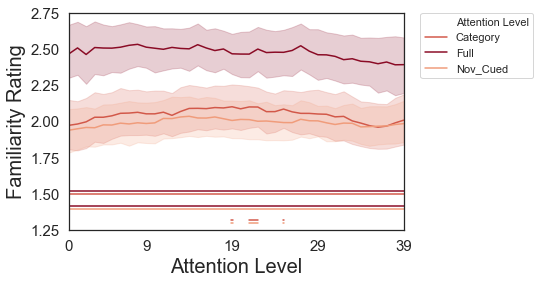

Experiment_2: Sliding Window - Same Category Images - Faces


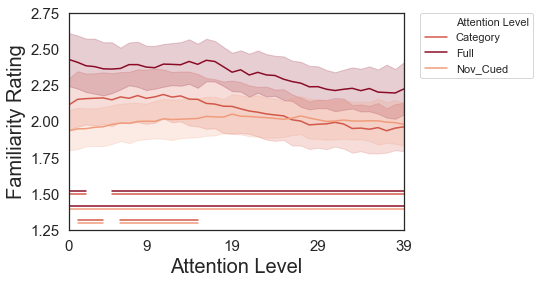

In [33]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
        
        
        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    

### Sliding Window - Images in Cued Location

Experiment_1: Sliding Window - Same Category Images - Faces
[True]
(0.0, 39.0)


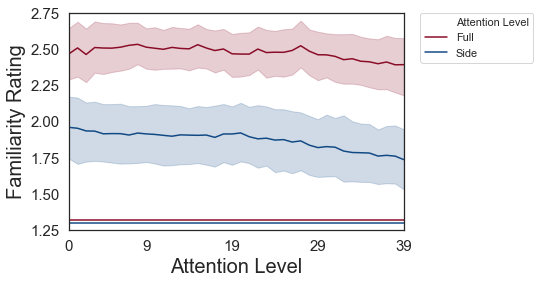

Experiment_2: Sliding Window - Same Category Images - Faces
[False]


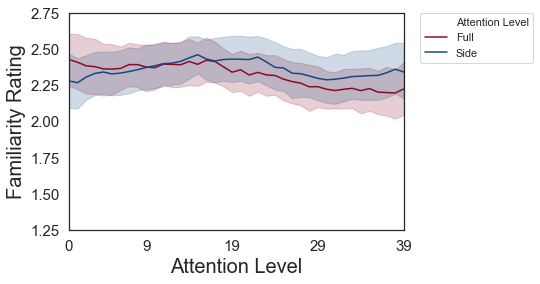

In [34]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)
    print(ttest_data[ttest_data['Attention Level']=='Side']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    

In [35]:
### Sliding Window - Images in Uncued Location

Experiment_1: Sliding Window - Same Category Images - Faces
[True]
(0.0, 39.0)


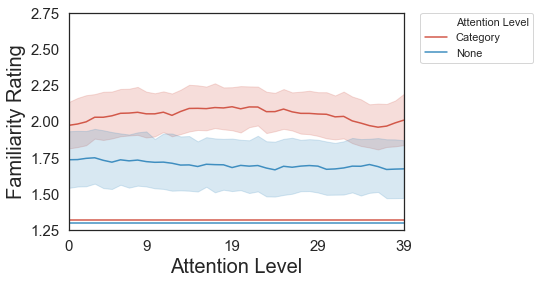

Experiment_2: Sliding Window - Same Category Images - Faces
[False True]
(30.0, 31.0)
(33.0, 35.0)
(37.0, 37.0)


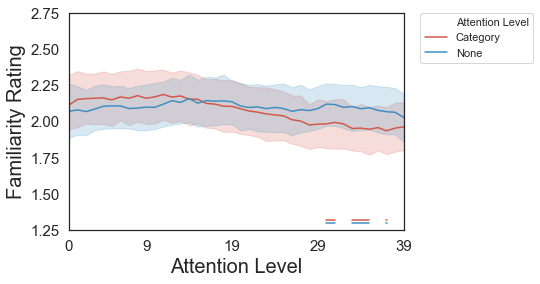

In [37]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)
    print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    